In [85]:
import math

class Value:
    def __init__(self, data, _children=(), _op="", label = "") -> None:
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label
    
    def __repr__(self) -> str:
        return f"Value(data={self.data})"
    
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), _op="+")

        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward  = _backward

        return out
    
    def __radd__(self, other): 
        return self + other
    
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data,(self, other), _op="*")

        def _backward():
            self.grad += out.grad * other.data
            other.grad += out.grad * self.data
        out._backward  = _backward

        return out
    
    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int/float powers for now"
        out = Value(self.data ** other,(self, ), _op=f"**{other}")

        def _backward():
            self.grad += other * (self.data ** (other - 1))  * out.grad

        out._backward  = _backward

        return out
    
    def __rmul__(self, other):
        return self * other
    
    def __truediv__(self, other):
        return self * other**(-1)
    
    def __neg__(self):
        return self * -1
    
    def __sub__(self, other):
        return self + (-other)
    
    

    
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t, (self,), "tanh")

        def _backward():
            self.grad += (1 - t ** 2) * out.grad

        out._backward  = _backward
        
        return out
    
    def exp(self):
        out = Value(math.exp(self.data), (self, ), "exp")
        def _backward():
            self.grad += out.data * out.grad
        
        out._backward = _backward

        return out
    
    def backward(self):
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)
        self.grad = 1.0
        for node in reversed(topo):
            node._backward()


In [56]:
a = Value(2.0)
b = Value(3.0)
a/b, b/a, a - b, b * a

(Value(data=0.6666666666666666),
 Value(data=1.5),
 Value(data=-1.0),
 Value(data=1.0))

In [3]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{%s | data %.4f | grad %.4f}" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

In [57]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'
o.backward()

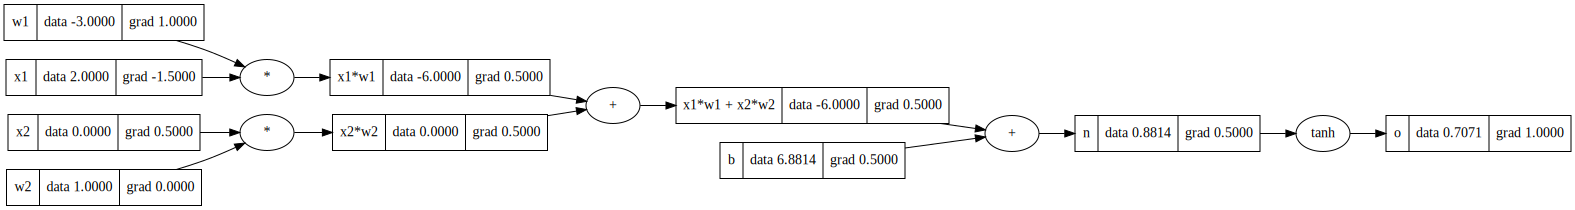

In [58]:
draw_dot(o)

In [63]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
e = (2*n).exp(); e.label = "e"
o = (e - 1) / (e + 1)
o.label = 'o'
o.backward()

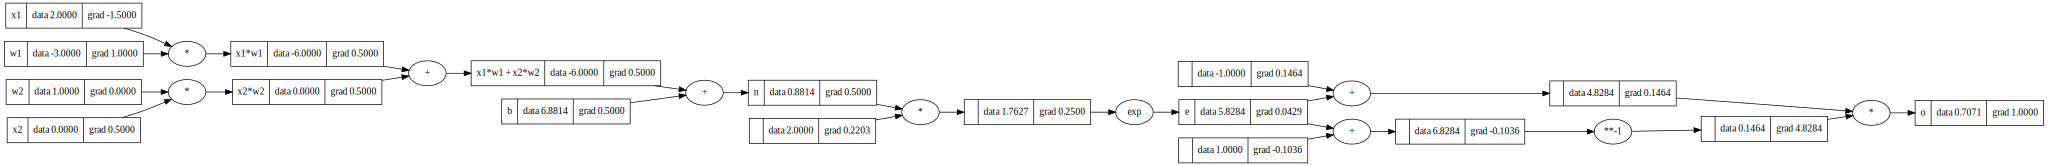

In [64]:
draw_dot(o)

In [86]:
s1 = Value(2.0, label='s1')
s2 = Value(0.1, label='s2')
sum([s1,s2])

Value(data=2.1)

In [68]:
import torch

# inputs x1,x2
x1 = torch.Tensor([2.0]).double()      ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()      ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()     ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()      ; w2.requires_grad = True

b = torch.Tensor([6.8813735870195432]).double()

n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('x1', x1.grad.item())
print('w1', w1.grad.item())
print('w2', w2.grad.item())
print('x2', x2.grad.item())




0.7071066904050358
x1 -1.5000003851533106
w1 1.0000002567688737
w2 0.0
x2 0.5000001283844369


In [2]:
import torch
torch.ones()

TypeError: ones() received an invalid combination of arguments - got (), but expected one of:
 * (tuple of ints size, *, tuple of names names, torch.dtype dtype, torch.layout layout, torch.device device, bool pin_memory, bool requires_grad)
 * (tuple of ints size, *, Tensor out, torch.dtype dtype, torch.layout layout, torch.device device, bool pin_memory, bool requires_grad)


In [145]:
import random

class Neuron:
    def __init__(self, nin) -> None:
        self.w = [Value(random.uniform(-1, 1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1, 1))

    def __call__(self, x):

        act = sum((w_i * x_i for w_i, x_i in zip(self.w, x)), self.b) 
        out = act.tanh()
        return out
    
    def parameters(self):
        return self.w + [self.b]
    
class Layer:
    def __init__(self, nin, nout) -> None:
        self.neurons = [Neuron(nin) for i in range(nout)]

    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs
    
    def parameters(self):
        params = []
        for neuron in self.neurons:
            ps = neuron.parameters()
            params.extend(ps)
        
        return params

class MLP:
    def __init__(self, nin, nouts) -> None:
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i + 1]) for i in range(len(nouts))]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
    
    def parameters(self):
        params = []
        for layer in self.layers:
            ps = layer.parameters()
            params.extend(ps)
        
        return params



In [164]:

x = [2.0, 3.0, -1.0]

n = MLP(nin=3,nouts=[4, 4, 1])
n(x)

Value(data=-0.9821190794573809)

In [165]:
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0]


In [166]:
for k in range(20):
    ypred = [n(x) for x in xs]
    loss = sum([((yout - ygt)**2) for ygt, yout in zip(ys, ypred)])
    
    for p in n.parameters():
        p.grad = 0.0 

    loss.backward()

    for p in n.parameters():
        p.data += -0.1 * p.grad
    print(k, loss.data)

0 8.106074432619724
1 7.903801098908906
2 7.862943033599243
3 7.814442436556581
4 7.740981854215175
5 7.607039955884666
6 7.297175448713002
7 6.246938287360459
8 1.9305480957380168
9 0.6237310985113008
10 0.12418301241960368
11 0.08504958807580688
12 0.06636329586568476
13 0.05463702355715507
14 0.04643245348805035
15 0.04033201406115991
16 0.03560959952684217
17 0.031844798511381556
18 0.028774255106470057
19 0.026223579025041202


In [167]:
[n(x) for x in xs]

[Value(data=0.9198333450853596),
 Value(data=-0.953458531583409),
 Value(data=-0.9094310360242225),
 Value(data=0.9146957254267554)]